In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers

# Carregar o dataset Fashion-MNIST
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalizar as imagens para [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 32

# Batch e shuffle dos dados
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [ ]:
def make_generator_model():
    """
    Constrói o modelo do gerador para a rede GAN.

    O modelo é composto por várias camadas que transformam um vetor de entrada aleatório
    em uma imagem 2D. Começa com uma camada densa e utiliza camadas de transposição convolucional
    para aumentar o tamanho da imagem passo a passo até o tamanho alvo.

    Retorna:
        Um modelo Sequential do Keras representando o gerador.
    """
    model = tf.keras.Sequential([
        # Começa com uma camada densa que recebe um vetor de ruído e produz uma saída 7x7x256
        layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        # Redimensiona a saída da camada densa para que possamos começar a transformação convolucional
        layers.Reshape((7, 7, 256)),

        # Várias camadas de transposição convolucional que aumentam gradualmente a imagem
        layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        # A última camada de transposição convolucional produz a imagem final com uma única camada de cor
        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

def make_discriminator_model():
    """
    Constrói o modelo do discriminador para a rede GAN.

    O discriminador é uma rede neural convolucional que classifica as imagens como reais ou falsas.
    Ele pega uma imagem como entrada e produz uma única saída de classificação.

    Retorna:
        Um modelo Sequential do Keras representando o discriminador.
    """
    model = tf.keras.Sequential([
        # A primeira camada convolucional pega uma imagem de entrada e aplica downsampling
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),  # Dropout para ajudar a prevenir overfitting

        # Segunda camada convolucional com downsampling
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        # Achatamento da saída para entrar na camada densa
        layers.Flatten(),

        # Última camada densa para classificação
        layers.Dense(1)
    ])
    return model


In [ ]:
# Instancia o modelo do gerador
generator = make_generator_model()

# Instancia o modelo do discriminador
discriminator = make_discriminator_model()

# Define a função de perda de entropia cruzada binária a ser usada por ambos os modelos
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    """
    Calcula a perda do discriminador combinando a perda das imagens reais e falsas.

    Parâmetros:
        real_output: as logits produzidas pelo discriminador para as imagens reais.
        fake_output: as logits produzidas pelo discriminador para as imagens falsas geradas pelo gerador.

    Retorna:
        A perda total do discriminador como um escalar.
    """
    # Perda nas imagens reais
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    # Perda nas imagens falsas
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    # perda total
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    """
    Calcula a perda do gerador baseada nas decisões do discriminador sobre as imagens falsas.

    Parâmetros:
        fake_output: as logits produzidas pelo discriminador para as imagens falsas geradas pelo gerador.

    Retorna:
        A perda do gerador como um escalar.
    """
    # Perda nas imagens falsas - quão bem o gerador engana o discriminador para classificar as falsas como reais
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Define o otimizador para o gerador com uma taxa de aprendizado de 1e-4
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
# Define o otimizador para o discriminador com uma taxa de aprendizado de 1e-4
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [ ]:
@tf.function
def train_step(images, k):
    """
    Realiza um passo de treinamento, atualizando tanto o discriminador quanto o gerador.

    Parâmetros:
    images: um lote de imagens reais do dataset.
    k: número de vezes que o discriminador deve ser atualizado por passo.

    Retorna:
    gen_loss: a perda calculada para o gerador neste passo.
    disc_loss: a perda calculada para o discriminador neste passo.
    """
    # Atualiza o discriminador 'k' vezes para cada atualização do gerador
    for _ in range(k):
        # Gera um lote de ruído para alimentar o gerador
        noise = tf.random.normal([BATCH_SIZE, 100])
        with tf.GradientTape() as disc_tape:
            # Gera imagens falsas
            generated_images = generator(noise, training=True)
            # Discrimina tanto as imagens reais quanto as falsas
            real_output = discriminator(images, training=True)
            fake_output = discriminator(generated_images, training=True)
            # Calcula a perda do discriminador com base nas duas saídas
            disc_loss = discriminator_loss(real_output, fake_output)
        # Calcula os gradientes para o discriminador
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        # Aplica os gradientes ao otimizador do discriminador
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # Gera um novo lote de ruído
    noise = tf.random.normal([BATCH_SIZE, 100])
    with tf.GradientTape() as gen_tape:
        # Gera imagens falsas
        generated_images = generator(noise, training=True)
        # Discrimina as imagens falsas
        fake_output = discriminator(generated_images, training=True)
        # Calcula a perda do gerador com base na saída do discriminador
        gen_loss = generator_loss(fake_output)
    # Calcula os gradientes para o gerador
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    # Aplica os gradientes ao otimizador do gerador
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    return gen_loss, disc_loss

def train(dataset, epochs, k=1):
    """
    Treina a GAN para um número definido de épocas.

    Parâmetros:
    dataset: o dataset de treinamento.
    epochs: o número total de épocas para treinar.
    k: o número de atualizações do discriminador por passo de treinamento.

    """
    # Itera por cada época
    for epoch in range(epochs):
        # Inicializa listas para armazenar perdas de cada batch
        gen_loss_list = []
        disc_loss_list = []
        # Itera por cada lote no dataset
        for image_batch in dataset:
            # Realiza um passo de treinamento e obtém as perdas
            gen_loss, disc_loss = train_step(image_batch, k)
            gen_loss_list.append(gen_loss)
            disc_loss_list.append(disc_loss)
        # Calcula a perda média para o gerador e discriminador na época
        mean_gen_loss = tf.reduce_mean(gen_loss_list)
        mean_disc_loss = tf.reduce_mean(disc_loss_list)
        # Imprime as perdas médias da época
        print(f'Epoch {epoch+1}, Generator Loss: {mean_gen_loss.numpy()}, Discriminator Loss: {mean_disc_loss.numpy()}')

# Inicia o treinamento do modelo
train(train_dataset, 200, k=1)


Epoch 1, Generator Loss: 1.4670166969299316, Discriminator Loss: 0.9346469640731812
Epoch 2, Generator Loss: 1.3118211030960083, Discriminator Loss: 1.0089961290359497
Epoch 3, Generator Loss: 1.1421592235565186, Discriminator Loss: 1.1024632453918457
Epoch 4, Generator Loss: 1.1906888484954834, Discriminator Loss: 1.0847840309143066
Epoch 5, Generator Loss: 1.0841121673583984, Discriminator Loss: 1.1308246850967407
Epoch 6, Generator Loss: 1.100494146347046, Discriminator Loss: 1.1323809623718262
Epoch 7, Generator Loss: 1.0209351778030396, Discriminator Loss: 1.1720236539840698
Epoch 8, Generator Loss: 1.014526605606079, Discriminator Loss: 1.1892465353012085
Epoch 9, Generator Loss: 0.963908851146698, Discriminator Loss: 1.2228502035140991
Epoch 10, Generator Loss: 0.9579676985740662, Discriminator Loss: 1.2224360704421997
Epoch 11, Generator Loss: 0.9284635782241821, Discriminator Loss: 1.2462365627288818
Epoch 12, Generator Loss: 0.9236403703689575, Discriminator Loss: 1.243657469

Visualizando dados reais

In [ ]:
# Carregar o dataset Fashion-MNIST
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

# Normalizar as imagens para o intervalo [0,1]
train_images = train_images / 255.0

# Labels correspondentes a cada classe
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


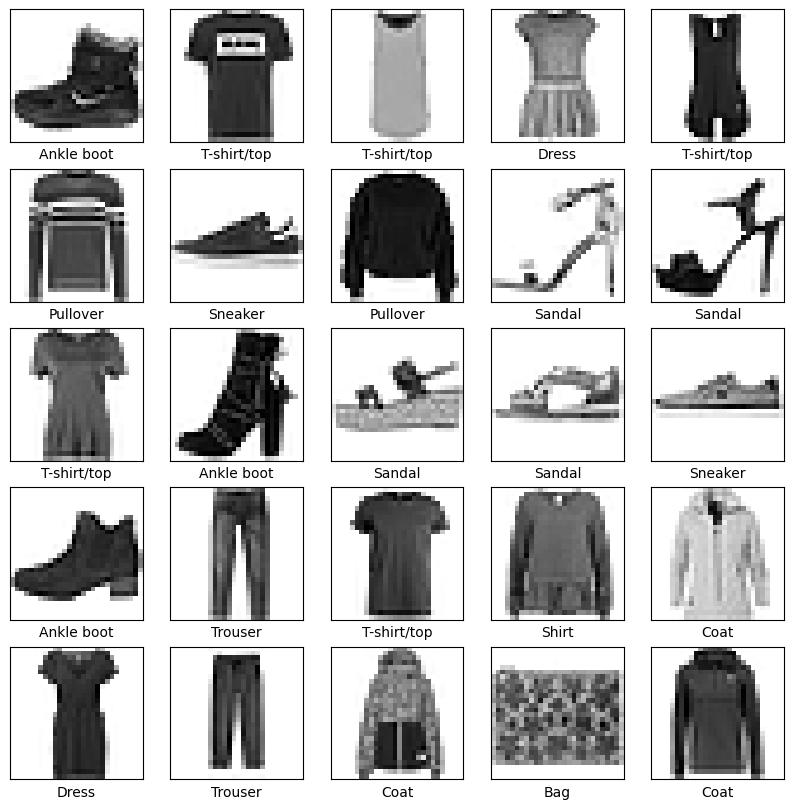

In [ ]:
# plotando imagens da base de dados
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()


Visualizando dados fakes

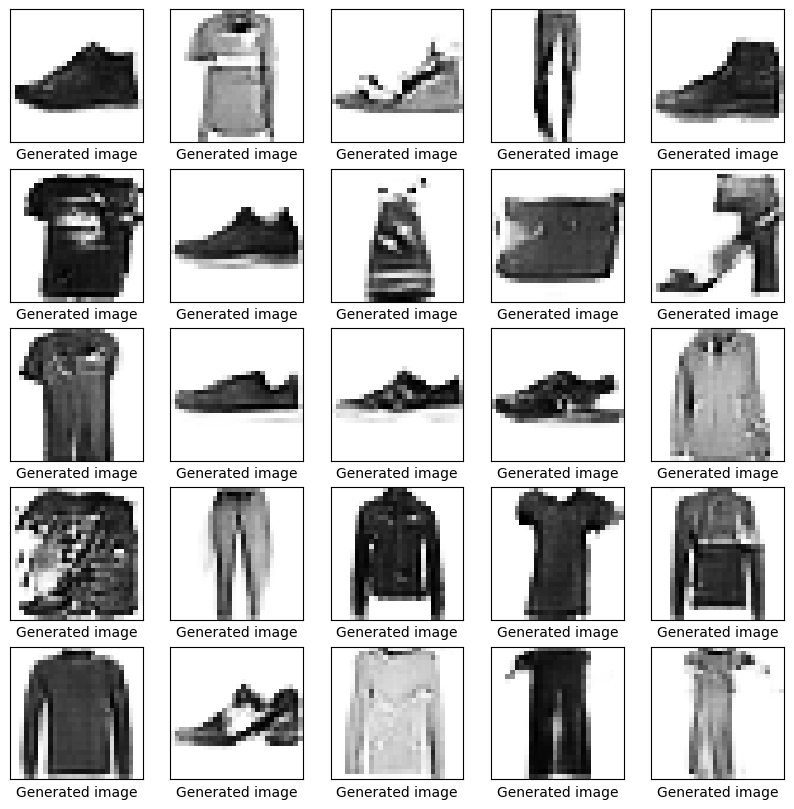

In [ ]:
def generate_and_show_images(model, num_images=25):
    # Gerar ruído aleatório como entrada para o modelo
    noise = tf.random.normal([num_images, 100])
    generated_images = model(noise, training=False)

    plt.figure(figsize=(10,10))  # Definir o tamanho da figura
    for i in range(num_images):
        plt.subplot(5, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        # Normalizar a imagem para o intervalo [0,1] para exibição
        plt.imshow((generated_images[i, :, :, 0] + 1) / 2, cmap=plt.cm.binary)
        plt.xlabel("Generated image")
    plt.show()

generate_and_show_images(generator)
